# Anomoly Detection Case

## Aim
The connectivity and flow of information and data between devices and sensors allows for an abundance of available data. The key enabler is then being able to use these vast amounts of available data and actually extract useful information, making it possible to reduce costs, optimize capacity, and keep downtime to a minimum. 

## Anomoly Detection Problem
Anomaly detection (or outlier detection) is the identification of rare items, events or observations which raise suspicions by differing significantly from the majority of the data. 

## Condition Monitoring Problem
Any machine, whether it is a rotating machine (pump, compressor, gas or steam turbine, etc.) or a non-rotating machine (heat exchanger, distillation column, valve, etc.) will eventually reach a point of poor health. That point might not be that of an actual failure or shutdown, but one at which the equipment is no longer acting in its optimal state. This signals that there might be need of some maintenance activity to restore the full operating potential. In simple terms, identifying the “health state” of our equipment is the domain of condition monitoring. The health of a complex piece of equipment cannot be reliably judged based on the analysis of each measurement on its own. We must rather consider a combination of the various measurements to get a true indication of the situation.

## Approach I: Multivariate statistical analysis
`Algorithm-Statistical Explain`: to detect anomalies in a more quantitative way, we first calculate the probability distribution p(x) from the normal group. Then when a new example, x, comes in, we compare p(x) with a threshold r. If p(x)<r, it is considered as an anomaly. This is because normal examples tend to have a large p(x) while anomalous examples tend to have a small p(x).

`Algorithm-Intuitive`: assume the original data follow a distribution D(e.g.Normal), then measure the MD between a point P and the distribution D. Then lassify the test point as an “anomaly” if the distance is above a certain threshold.

`Mahalanobis distance`: measurement of the distance between a point P and a distribution D. This distance is zero for P at the mean of D and grows as P moves away from the mean along each principal component axis.

`PCA`: as dealing with high dimensional data is often challenging, there are several techniques to reduce the number of variables (dimensionality reduction). One of the main techniques is principal component analysis (PCA), which performs a linear mapping of the data to a lower-dimensional space in such a way that the variance of the data in the low-dimensional representation is maximized. 

`Disadvantage`: strong assumption that the original data points follow normal distribution, which might not be.

`Advantage`: The Mahalanobis distance is thus unitless, scale-invariant, and takes into account the correlations of the data set.

`Issue with this Algo to our problem`: we actually change from the original topic `Anomoly Detection` to `Condition Monitoring` in that we did not use the original upper and lower limit of the upset directly in our model, instead, we 'create' a new threshold based on the distribution of the data(e.g. u +- 3sigma).

REF: 
- MD: https://en.wikipedia.org/wiki/Mahalanobis_distance 
- Algorithm&Application: https://towardsdatascience.com/how-to-use-machine-learning-for-anomaly-detection-and-condition-monitoring-6742f82900d7, https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770
- Elliptical distribution: https://en.wikipedia.org/wiki/Elliptical_distribution
- PCA:https://en.wikipedia.org/wiki/Principal_component_analysis#:~:text=Principal%20component%20analysis%20(PCA)%20is,the%20visualization%20of%20multidimensional%20data.

# Importing libraries

Defining important variables and importing required libraries 

In [7]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
from scipy import stats
%matplotlib inline
from distfit import distfit

from numpy.random import seed

# Data loading and pre-processing:

In [16]:
df = pd.read_pickle('61plus.pkl')

In [17]:
df.head()

,Unnamed: 0,new_id,low_limit_x,up_limit_x,final_value,new_date_x
0,6508163,200518203254_11S03FP078YL10BG05E0XA_r11_i2c_rep,44.91,59.88,50.11436,200518
1,6643561,200518203254_11S03FP078YL10BG05E0XA_r13_i2c_rep,44.91,59.88,50.21467,200518
2,6751902,200518203254_11S03FP078YL10BG05E0XA_r14_i2c_rep,44.91,59.88,51.71618,200518
3,7266343,200518203254_11S03FP078YL10BG05E0XA_r1_j1_b2t,44.91,59.88,50.20717,200518
4,7293418,200518203254_11S03FP078YL10BG05E0XA_r1_j1_nvclk,44.91,59.88,50.29527,200518


In [18]:
df.shape

(1048575, 6)

## Separate Analysis

In [23]:
# Select the normal cases
df_normal = df.loc[(df.final_value >= df.low_limit_x) & (df.final_value <= df.up_limit_x)]['final_value']

In [27]:
df_abnormal = df.loc[(df.final_value < df.low_limit_x) | (df.final_value > df.up_limit_x)]['final_value']

In [25]:
df_normal.describe()

count    1.047937e+06
mean     5.186500e+01
std      1.907892e+00
min      4.529807e+01
25%      5.014673e+01
50%      5.067920e+01
75%      5.351734e+01
max      6.119656e+01
Name: final_value, dtype: float64

<Axes: ylabel='Frequency'>

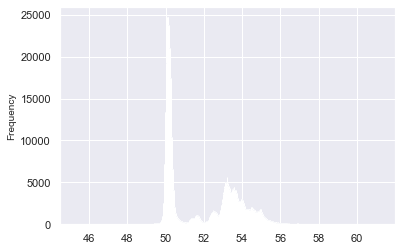

In [29]:
df_normal.plot(kind='hist', bins=1000)

In [42]:
df_normal.shape

(1047937,)

In [28]:
df_abnormal.describe()

count    638.000000
mean      67.400728
std       15.426030
min       57.385840
25%       60.068970
50%       62.305160
75%       68.100835
max      208.883000
Name: final_value, dtype: float64

<Axes: ylabel='Frequency'>

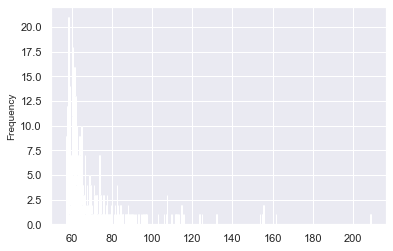

In [30]:
df_abnormal.plot(kind='hist', bins=1000)

In [43]:
df_abnormal.shape

(638,)

## KS check the distribution of the data

REF: 
- Distribution Fitting with Python SciPy: https://medium.com/@amirarsalan.rajabi/distribution-fitting-with-python-scipy-bb70a42c0aed
- Kolmogorov-Smirnov Goodness-of-Fit Test: https://www.itl.nist.gov/div898/handbook/eda/section3/eda35g.htm

In [31]:
# Assume a normal distribution of the data
dist = getattr(stats, 'norm')
parameters = dist.fit(df_normal)
print(parameters)

(51.86500194034566, 1.9078907120119106)


In [32]:
# Kolmogorov test
stats.kstest(df_normal, "norm", parameters)

KstestResult(statistic=0.2544371569057765, pvalue=0.0)

This prove the unlikelihood of the data from normal group belonging to a normal distribution

In [41]:
# # Test the distribution of the original data
# list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford',
#                  'burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull',
#                  'erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife',
#                  'fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic',
#                  'genpareto','gennorm','genexpon','genextreme','gausshyper','gamma',
#                  'gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l',
#                  'halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss',
#                  'invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic',
#                  'loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf',
#                  'nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal',
#                  'rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm',
#                  'tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
# results = []
# for i in list_of_dists:
#     dist = getattr(stats, i)
#     param = dist.fit(df['final_value'])
#     a = stats.kstest(df['final_value'], i, args=param)
#     results.append((i,a[0],a[1]))
    
    
# results.sort(key=lambda x:float(x[2]), reverse=True)
# for j in results:
#     print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

## Distfit to check the distribution of the data

Algorithm
- Compute the fit for your random variable across various PDFs, then rank PDFs using the goodness of fit test, and evaluate with a bootstrap approach. Note that non-parametric approaches with quantiles or percentiles can also be used.
- Visually inspect the histogram, PDFs, CDFs, and Quantile-Quantile (QQ) plot.
- Choose the best model based on steps 1 and 2, but also make sure the properties of the (non-)parametric model (e.g., the PDF) match the use case. Choosing the best model is not just a statistical question; it is also a modeling decision.
- Make predictions on new unseen samples using the (non-)parametric model such as the PDF.

REF: 
- Outlier detection univariate: https://towardsdatascience.com/outlier-detection-using-distribution-fitting-in-univariate-data-sets-ac8b7a14d40e
- How to find distribution of ur data: https://towardsdatascience.com/how-to-find-the-best-theoretical-distribution-for-your-data-a26e5673b4bd

[distfit] >INFO> fit
[distfit] >INFO> transform
[distfit] >INFO> [norm      ] [0.63 sec] [RSS: 6.83001] [loc=51.865 scale=1.908]                                       
[distfit] >INFO> [expon     ] [0.66 sec] [RSS: 8.10904] [loc=45.298 scale=6.567]                                       
[distfit] >INFO> [pareto    ] [76.8 sec] [RSS: 8.21428] [loc=-0.344 scale=45.642]                                      
[distfit] >INFO> [dweibull  ] [44.3 sec] [RSS: 5.34409] [loc=51.985 scale=1.978]                                       
[distfit] >INFO> [t         ] [56.9 sec] [RSS: 6.8296] [loc=51.867 scale=1.909]                                        
[distfit] >INFO> [genextreme] [70.2 sec] [RSS: 6.43649] [loc=50.907 scale=1.429]                                       
[distfit] >INFO> [gamma     ] [16.4 sec] [RSS: 6.68446] [loc=45.296 scale=0.532]                                       
[distfit] >INFO> [lognorm   ] [102. sec] [RSS: 6.60626] [loc=45.281 scale=6.321]                                

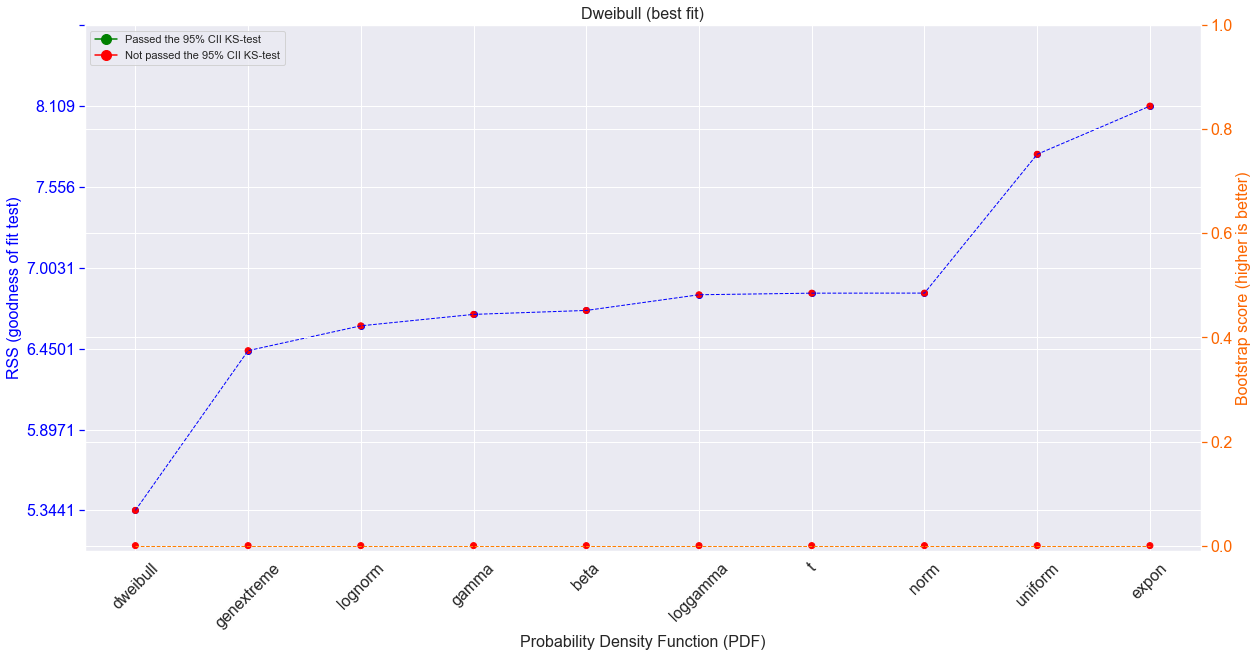

In [33]:
# Initialize for common/popular distributions with bootstrapping.
dfit = distfit(distr='popular', n_boots=100)

# Estimate the best fit
results = dfit.fit_transform(df_normal)

# Plot the RSS and bootstrap results for the top scoring PDFs
dfit.plot_summary(n_top=10)

# Show the plot
plt.show()

[distfit] >INFO> Create PDF plot for the parametric method.
[distfit] >INFO> Estimated distribution: Dweibull(loc:51.984843, scale:1.977941)
[distfit] >INFO> Create CDF plot for the parametric method.
[distfit] >INFO> Ploting CDF


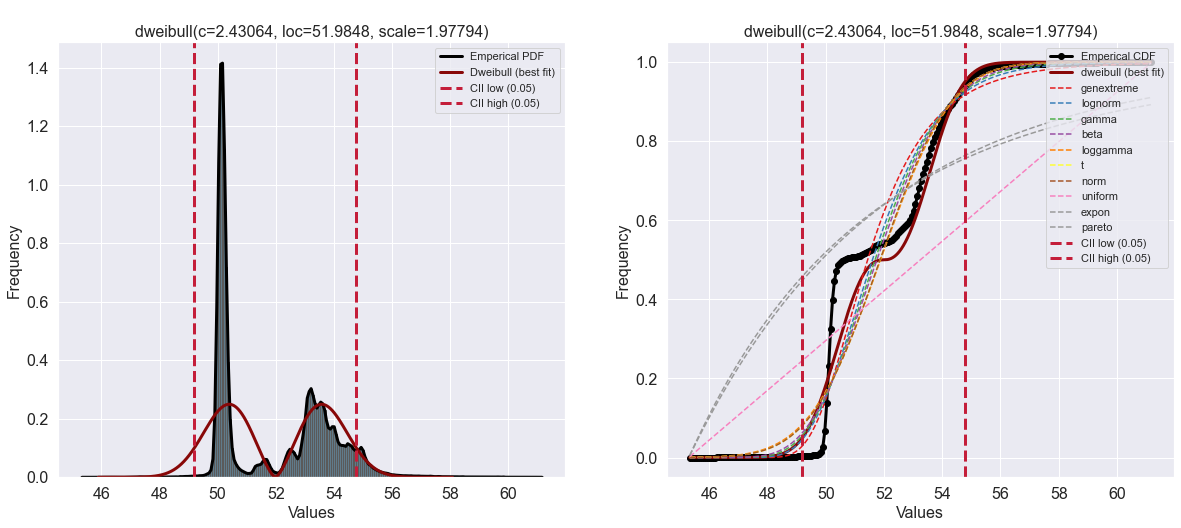

In [34]:
# Make figure
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# PDF for only the best fit
dfit.plot(chart='PDF', n_top=1, ax=ax[0]);

# CDF for the top 10 fits
dfit.plot(chart='CDF', n_top=10, ax=ax[1])

# Show the plot
plt.show()

To summarize, the Dweibull distribution may be the best choice in this particular use case after considering the goodness of fit test, the bootstrap approach, the visual inspection.

In [36]:
df_univariate = df['final_value']

[distfit] >INFO> Alpha is set to [0.005]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 1047937 samples.


(<Figure size 1800x864 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=2.43064, loc=51.9848, scale=1.97794)'}, xlabel='x-axes', ylabel='y-axes'>)

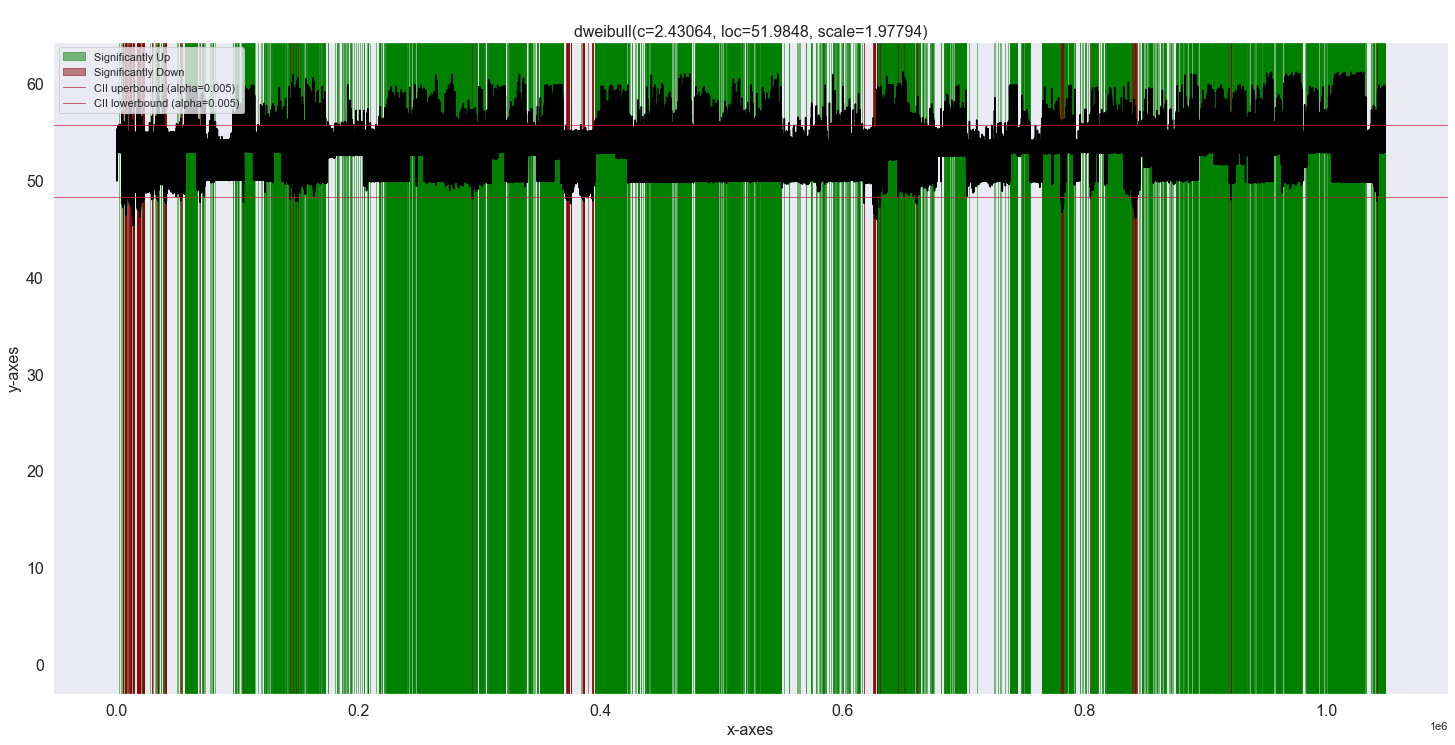

In [40]:
# Make prediction
dfit.predict(df_normal.values, alpha=0.005, multtest=None)

# Line plot with data points outside the confidence interval.
dfit.lineplot(df_normal, labels=df_normal.index)

[distfit] >INFO> Alpha is set to [0.0005]
[distfit] >INFO> Compute confidence intervals [parametric]
[distfit] >INFO> Compute significance for 1048575 samples.


(<Figure size 1800x864 with 1 Axes>,
 <Axes: title={'center': '\ndweibull(c=2.43064, loc=51.9848, scale=1.97794)'}, xlabel='x-axes', ylabel='y-axes'>)

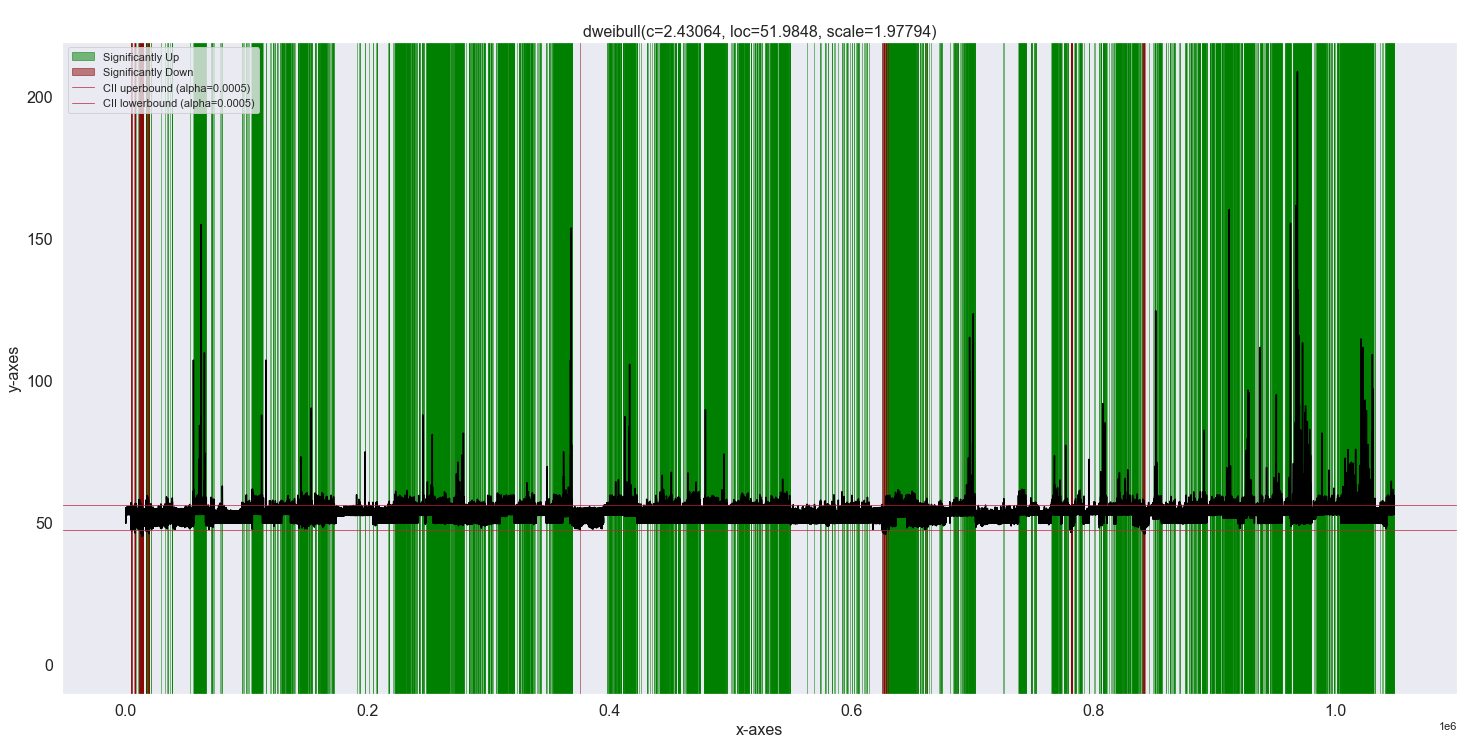

In [44]:
# Make prediction
dfit.predict(df_univariate.values, alpha=0.0005, multtest=None)

# Line plot with data points outside the confidence interval.
dfit.lineplot(df_univariate, labels=df.index)

# MD method

# Define train/test data:

In [45]:
df.drop(columns=['Unnamed: 0', 'new_id','new_date_x'], inplace=True)

In [46]:
df.dropna(inplace=True)

In [47]:
df.shape

(1048575, 3)

In [48]:
dataset_train = df.iloc[:800000]
dataset_test = df.iloc[800000:]

In [49]:
print('Train data vs Test data {}'.format(round(dataset_train.shape[0]/dataset_test.shape[0], 2)))

Train data vs Test data 3.22


# PCA type model for anomaly detection:

In [50]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(dataset_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = dataset_train.index

X_test_PCA = pca.transform(dataset_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = dataset_test.index

# The Mahalanobis distance Classifier:

In [51]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [52]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [53]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [54]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [55]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [56]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [57]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [58]:
mean_distr = data_train.mean(axis=0)

In [67]:
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

In [68]:
threshold

3.733362035045491

(0.0, 15.0)

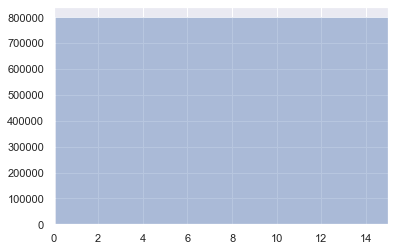

In [69]:
# We start by visualizing the square of the Mahalanobis distance, which should then ideally follow a χ2 distribution.
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

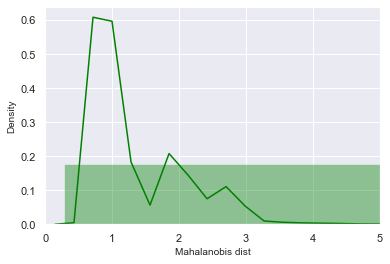

In [70]:
# Then visualize the Mahalanobis distance itself:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

From the above distributions, the calculated threshold value of 2.55 for flagging an anomaly seems reasonable (defined as 3 standard deviations from the center of the distribution)

In [71]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
800000,1.917747,3.733362,False
800001,1.966191,3.733362,False
800002,1.958155,3.733362,False
800003,1.219612,3.733362,False
800004,1.243093,3.733362,False


In [72]:
anomaly.describe()

,Mob dist,Thresh
count,248575.000000,2.485750e+05
mean,1.376619,3.733362e+00
std,0.831177,2.664541e-15
min,0.279072,3.733362e+00
25%,0.848027,3.733362e+00
50%,1.100706,3.733362e+00
75%,1.933584,3.733362e+00
max,86.026227,3.733362e+00


In [73]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])

# Verifying PCA model on test data:

<Axes: >

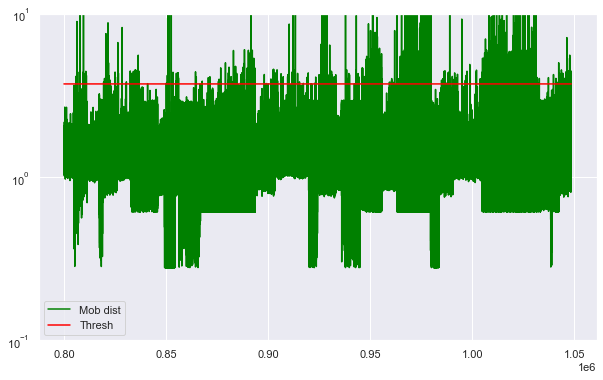

In [74]:
anomaly.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e1], color = ['green','red'])

# Verifying PCA model with actual flagging:

## Truth flagging

In [88]:
# Compared with actual flagging
df_truth = df[['P86_FROTH_MINERAL']]
df_truth['Thre'] = 14 
df_truth['Flag'] = False
df_truth.loc[df['P86_FROTH_MINERAL']>14, 'Flag'] = True

C:\Users\XiaoShuoCui\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\XiaoShuoCui\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\XiaoShuoCui\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [95]:
df_truth.loc[df['P86_FROTH_MINERAL']>14, 'Flag'].index

DatetimeIndex(['2021-06-08 23:00:00+00:00', '2021-06-08 23:05:00+00:00',
               '2021-06-08 23:10:00+00:00', '2021-06-08 23:15:00+00:00',
               '2021-06-08 23:20:00+00:00', '2021-06-08 23:25:00+00:00',
               '2021-06-08 23:30:00+00:00', '2021-06-08 23:35:00+00:00',
               '2021-06-08 23:40:00+00:00', '2021-06-08 23:45:00+00:00',
               ...
               '2021-06-09 10:10:00+00:00', '2021-06-09 10:15:00+00:00',
               '2021-06-09 10:20:00+00:00', '2021-06-09 10:25:00+00:00',
               '2021-06-09 10:30:00+00:00', '2021-06-09 10:35:00+00:00',
               '2021-06-09 10:40:00+00:00', '2021-06-09 10:45:00+00:00',
               '2021-06-09 10:50:00+00:00', '2021-06-09 10:55:00+00:00'],
              dtype='datetime64[ns, UTC]', name='timestamp_utc', length=144, freq=None)

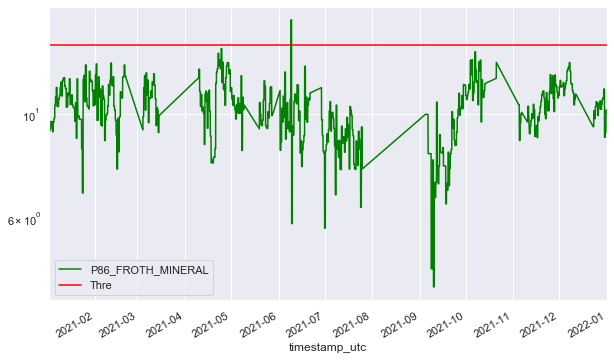

In [91]:
df_truth.plot(logy=True, figsize = (10,6), color = ['green','red'])

## Predicted flagging

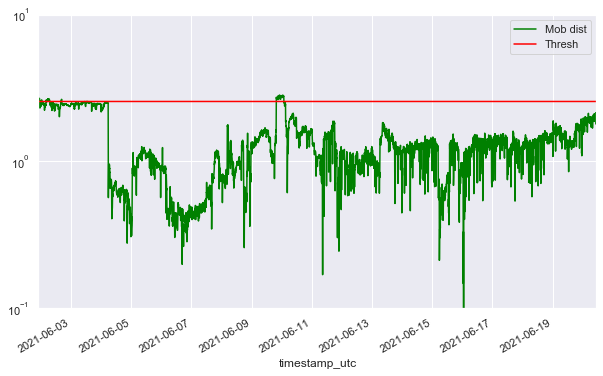

In [94]:
df_loc_truth = anomaly_train['2021-06-01 22:00:00': '2021-06-20 10:55:00']
df_loc_truth.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e1], color = ['green','red'])

visualize the model output in the time leading up to the bearing failure: we can predict the anomoly like 2 days earlier

`Summary`: results show that they are able to flag the upcoming bearing malfunction well in advance of the actual failure. The main difference is essentially how to define a suitable threshold value for flagging anomalies, to avoid to many false positives during normal operating conditions.